In [1]:
from RADARDataCapture import FMCWRADARDataCapture
from MOCAPDataCapture import MOCAPDataCapture
from FPDataCapture import FPDataCapture
from StableRdmDataset import StableRdmDataset
import h5py
import os
import numpy as np
import pandas as pd
import imageio
import matplotlib.pyplot as plt
from datetime import datetime
import statistics
from matplotlib import animation
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch import optim
from datetime import datetime
from RdmSingleVariablePrediction import RdmCNNLSTMModel
from sklearn.model_selection import KFold
from scipy import stats
import random

Load Events csv

In [2]:
event_csv_path = "/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/csvs/MOCAP_FP_RADAR_FU_Stable_Break_FD_TIME_FRAMES_v3.csv"

event_labels_df = pd.read_csv(event_csv_path)
print(event_labels_df.head())

    RADAR_capture  MOCAP_Start_Time  MOCAP_End_Time  RADAR_Start_Frame  \
0  01_MNTRL_RR_V1              7.33           30.57                194   
1  01_MNTRL_RR_V1              7.33           30.57                194   
2  01_MNTRL_RR_V1              7.33           30.57                194   
3  01_MNTRL_RR_V2              7.37           30.40                191   
4  01_MNTRL_RR_V2              7.37           30.40                191   

   RADAR_End_Frame  Seconds_per_Frame  tx  is_final_tx  t_foot_up  t_stable  \
0              831            0.03645   1        False      10.22     11.19   
1              831            0.03645   2        False      18.25     19.05   
2              831            0.03645   3         True      26.24     27.03   
3              822            0.03646   1        False      10.48     11.05   
4              822            0.03646   2        False      18.41     19.07   

   t_break  t_foot_down  frame_foot_up  frame_stable  frame_break  frame_end  
0

Training and Testing Functions

In [3]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=25, device=torch.device("cpu")):
    """
    Train a model on a given dataset.

    Parameters:
    - model: The neural network model to be trained.
    - dataloader: DataLoader for the training data.
    - criterion: The loss function.
    - optimizer: The optimization algorithm.
    - num_epochs: The number of epochs to train for.
    - device: The device (CPU or GPU) to train on.

    Returns:
    - model: The trained model.
    """

    # Move model to the specified device
    model.to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        model.train()  # Set model to training mode
        running_loss = 0.0

        # Iterate over data
        for inputs, velocities, _, _ in dataloader:
            inputs = inputs.to(device)
            velocities = velocities.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, velocities)

            # Backward pass + optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Train Loss: {epoch_loss:.4f}\n')

    print('Training complete')
    return model


def train_validate_model(model, dataloaders, criterion, optimizer, num_epochs=25, device=torch.device("cpu")):
    
    best_val_loss = float('inf')

    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            
            # Iterate over data.
            for inputs, velocities, _, _ in dataloaders[phase]:
                inputs = inputs.to(device)
                velocities = velocities.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, velocities)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f}')

                # Track the best performance
            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                print(f"New best validation loss is: {best_val_loss}")
        
        print()

    print('Training complete')

    return model, best_val_loss

def test_model(model, dataloader, device=torch.device("cpu")):
    model.eval()  # Set model to evaluate mode
    running_loss = 0.0
    criterion = nn.MSELoss()  # Example criterion, adjust as necessary

    # No gradient updates
    with torch.no_grad():
        for inputs, velocities, _, _ in dataloader:
            inputs = inputs.to(device)
            velocities = velocities.to(device)

            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, velocities)

            # Statistics
            running_loss += loss.item() * inputs.size(0)

    total_loss = running_loss / len(dataloader.dataset)
    print(f'Test Loss: {total_loss:.4f}')


K-Fold Crossvalidation

In [4]:
root_dir = '/Volumes/FourTBLaCie/Yoga_Study_RADAR_Stable_1Ch'
event_csv = "/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/csvs/MOCAP_FP_RADAR_FU_Stable_Break_FD_TIME_FRAMES_v3.csv"

# Get all folders and shuffle them randomly
all_folders = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
random.seed(42)  # Replace 42 with any seed number you prefer
random.shuffle(all_folders)

# Calculate the number of folders for each set
num_train_folders = int(len(all_folders) * 0.7)
num_val_folders = int(len(all_folders) * 0.15)
num_test_folders = len(all_folders) - (num_train_folders + num_val_folders)

training_crossvalidation_folders = all_folders[:num_train_folders + num_val_folders]
test_folders = all_folders[num_train_folders + num_val_folders:]

training_crossvalidation_folders = ['13', '22', '12', '10', '24', '14', '08', '03', '01', '15', '04', '16']
test_folders = ['18', '02', '05']

print(f'Cross-validation folders: {training_crossvalidation_folders}')
print(f'Test folders: {test_folders}')

# Define the setup_loaders function
def setup_loaders(root_dir, event_csv, folders):
    datasets = {}
    loaders = {}

    # Check if each key exists before attempting to create a dataset for it
    for x in ['train', 'val', 'test']:
        if x in folders:
            datasets[x] = StableRdmDataset(root_dir, event_csv, folders[x], label_type="avg_speed")
            loaders[x] = DataLoader(datasets[x], batch_size=2, shuffle=True if x == 'train' else False, collate_fn=StableRdmDataset.collate_fn)

    return loaders

# Assign test folders 
test_folders_dict = {'test': test_folders} 

# Create the test DataLoader
loaders = setup_loaders(root_dir, event_csv, test_folders_dict)
test_loader = loaders['test']

print(test_loader)

date_time_string = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

kf = KFold(n_splits=len(training_crossvalidation_folders))  # For example, 5-fold cross-validation
fold_performance = []

for train_index, val_index in kf.split(training_crossvalidation_folders):
    train_folders = np.array(training_crossvalidation_folders)[train_index]
    val_folders = np.array(training_crossvalidation_folders)[val_index]
    print(f'Train folders: {train_folders}')
    print(f'Val folders: {val_folders}')
    

    # Create dataloaders for the current fold
    folders = {
        'train': train_folders.tolist(),
        'val': val_folders.tolist()
    }
    loaders = setup_loaders(root_dir, event_csv, folders)
    train_loader, val_loader = loaders['train'], loaders['val']

    # Train and validate the model on this fold
    # Initialize the model
    num_channels = 1  # For radar data, this might be 1 if it's grayscale
    hidden_dim = 128
    lstm_layers = 2
    bidirectional = False
    model = RdmCNNLSTMModel(num_channels, hidden_dim, lstm_layers, bidirectional)
        
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    dataloaders = {'train': train_loader, 'val': val_loader}

    # Train and validate
    model, best_val_loss = train_validate_model(model, dataloaders, criterion, optimizer, num_epochs=3, device=device)
    
    model_dir ='/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/OneFoldCV_models_v5/'
    os.makedirs(model_dir, exist_ok=True)
    model_file_name= f'model_{train_index}_{date_time_string}.pth'
    model_path = os.path.join(model_dir, model_file_name)
    
    # Saving the entire model (architecture + weights)
    torch.save(model, model_path)

    # Optionally, evaluate fold performance here or after all folds are complete
    fold_performance.append(best_val_loss)  # Add this fold's performance to the list

# Calculate average performance across all folds
average_performance = np.mean(fold_performance)
print(f'Average performance across all folds: {average_performance}')


Cross-validation folders: ['13', '22', '12', '10', '24', '14', '08', '03', '01', '15', '04', '16']
Test folders: ['18', '02', '05']
found capture tx: /Volumes/FourTBLaCie/Yoga_Study_RADAR_Stable_1Ch/18/18_MNTRL_RR_V1_channel1_tx1.npy
The shape of the cpature is (86, 23, 13)
found capture tx: /Volumes/FourTBLaCie/Yoga_Study_RADAR_Stable_1Ch/18/18_MNTRL_RR_V1_channel2_tx1.npy
The shape of the cpature is (86, 23, 13)
found capture tx: /Volumes/FourTBLaCie/Yoga_Study_RADAR_Stable_1Ch/18/18_MNTRL_RR_V1_channel3_tx1.npy
The shape of the cpature is (86, 23, 13)
found capture tx: /Volumes/FourTBLaCie/Yoga_Study_RADAR_Stable_1Ch/18/18_MNTRL_RR_V1_channel4_tx1.npy
The shape of the cpature is (86, 23, 13)
found capture tx: /Volumes/FourTBLaCie/Yoga_Study_RADAR_Stable_1Ch/18/18_MNTRL_RR_V1_channel1_tx2.npy
The shape of the cpature is (92, 23, 13)
found capture tx: /Volumes/FourTBLaCie/Yoga_Study_RADAR_Stable_1Ch/18/18_MNTRL_RR_V1_channel2_tx2.npy
The shape of the cpature is (92, 23, 13)
found capt

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


train Loss: 0.0050
val Loss: 0.0003
New best validation loss is: 0.00025117048444798227

Epoch 2/3
----------
train Loss: 0.0033
val Loss: 0.0021

Epoch 3/3
----------
train Loss: 0.0031
val Loss: 0.0030

Training complete
Train folders: ['13' '12' '10' '24' '14' '08' '03' '01' '15' '04' '16']
Val folders: ['22']
found capture tx: /Volumes/FourTBLaCie/Yoga_Study_RADAR_Stable_1Ch/13/13_MNTRL_RR_V1_channel1_tx1.npy
The shape of the cpature is (27, 23, 13)
found capture tx: /Volumes/FourTBLaCie/Yoga_Study_RADAR_Stable_1Ch/13/13_MNTRL_RR_V1_channel2_tx1.npy
The shape of the cpature is (27, 23, 13)
found capture tx: /Volumes/FourTBLaCie/Yoga_Study_RADAR_Stable_1Ch/13/13_MNTRL_RR_V1_channel3_tx1.npy
The shape of the cpature is (27, 23, 13)
found capture tx: /Volumes/FourTBLaCie/Yoga_Study_RADAR_Stable_1Ch/13/13_MNTRL_RR_V1_channel4_tx1.npy
The shape of the cpature is (27, 23, 13)
found capture tx: /Volumes/FourTBLaCie/Yoga_Study_RADAR_Stable_1Ch/13/13_MNTRL_RR_V1_channel1_tx2.npy
The shape o

KeyboardInterrupt: 

Test participants

Processing model: model_[ 0  1  2  3  4  6  7  8  9 10 11]_2024-03-27_15-54-31.pth
Loading model from /Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/OneFoldCV_models_v4/model_[ 0  1  2  3  4  6  7  8  9 10 11]_2024-03-27_15-54-31.pth
Processing model: model_[ 0  1  2  3  4  5  6  8  9 10 11]_2024-03-27_15-54-31.pth
Loading model from /Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/OneFoldCV_models_v4/model_[ 0  1  2  3  4  5  6  8  9 10 11]_2024-03-27_15-54-31.pth
Processing model: model_[ 0  1  3  4  5  6  7  8  9 10 11]_2024-03-27_15-54-31.pth
Loading model from /Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/OneFoldCV_models_v4/model_[ 0  1  3  4  5  6  7  8  9 10 11]_2024-03-27_15-54-31.pth
Processing model: model_[ 0  1  2  3  4  5  7  8  9 10 11]_2024-03-27_15-54-31.pth
Loading model from /Users/danielcopeland/Library/M

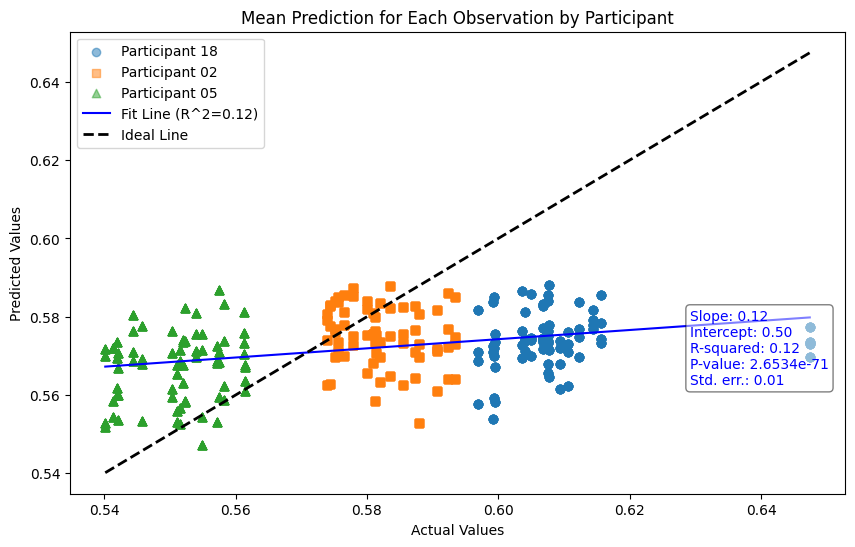

In [8]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from torch.utils.data import DataLoader

# Assuming RdmCNNLSTMModel and setup_loaders are defined

def load_model(model_path, device):
    print(f"Loading model from {model_path}")
    model = RdmCNNLSTMModel(num_channels=1, hidden_dim=128, lstm_layers=2, bidirectional=False)
    model = torch.load(model_path, map_location=device)
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    return model

def evaluate_model(model, test_loader, device):
    model.eval()
    predictions = []
    actuals = []
    participant_ids = []  # Store participant IDs
    with torch.no_grad():
        for inputs, labels, _, metadata in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.view(-1).cpu().numpy())
            actuals.extend(labels.view(-1).cpu().numpy())
            # Assuming metadata contains participant ID information
            participant_ids.extend([meta['RADAR_capture'][:2] for meta in metadata])
    return predictions, actuals, participant_ids

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_dir = "/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/OneFoldCV_models_v4"

# Initialize an empty list to collect all model predictions and actuals
all_model_results = []

# Loop over each model in the model directory
for model_name in os.listdir(model_dir):
    if model_name.endswith('.pth'):
        model_path = os.path.join(model_dir, model_name)
        print(f"Processing model: {model_name}")
        model = load_model(model_path, device)
        predictions, actuals, participant_ids = evaluate_model(model, test_loader, device)
        all_model_results.append((predictions, actuals, participant_ids))


unique_participants = test_folders

plt.figure(figsize=(10, 6))

# Define markers and colors for participants
markers = ['o', 's', '^', '<', '>', 'p', '*', 'h', 'x', 'D']  # Example markers

# Prepare to collect all mean predictions and actuals
all_mean_predictions = []
all_mean_actuals = []

# Assuming `all_model_results` is structured like [(predictions, actuals, participant_ids), ...] for each model
for i, participant in enumerate(unique_participants):
    # Initialize lists to store individual observation means for this participant
    participant_observation_means_pred = []
    participant_observation_means_act = []

    # Collect all predictions and actuals for this participant across models
    for predictions, actuals, participant_ids in all_model_results:
        for obs_idx in range(len(participant_ids)):
            if participant_ids[obs_idx] == participant:
                # For each observation belonging to the current participant, collect across all models
                all_preds_for_obs = [predictions[obs_idx] for predictions, _, ids in all_model_results if ids[obs_idx] == participant]
                all_actuals_for_obs = [actuals[obs_idx] for _, actuals, ids in all_model_results if ids[obs_idx] == participant]
                
                # Compute the mean prediction for this observation across all models
                participant_observation_means_pred.append(np.mean(all_preds_for_obs))
                # The actuals should be the same across all models, so just take the mean to keep dimensions consistent
                participant_observation_means_act.append(np.mean(all_actuals_for_obs))
    
    # Add the computed means for this participant to the overall list
    all_mean_predictions.extend(participant_observation_means_pred)
    all_mean_actuals.extend(participant_observation_means_act)
    
    # Plot the mean predictions for this participant's observations
    marker = markers[i % len(markers)]  # Cycle through markers
    plt.scatter(participant_observation_means_act, participant_observation_means_pred, alpha=0.5, label=f'Participant {participant}', marker=marker)

# Perform linear regression on the aggregated means
slope, intercept, r_value, p_value, std_err = linregress(all_mean_actuals, all_mean_predictions)
line_x = np.linspace(min(all_mean_actuals), max(all_mean_actuals), 100)
line_y = slope * line_x + intercept

plt.plot(line_x, line_y, color='blue', label=f'Fit Line (R^2={r_value**2:.2f})')
plt.plot([min(all_mean_actuals), max(all_mean_actuals)], [min(all_mean_actuals), max(all_mean_actuals)], 'k--', lw=2, label='Ideal Line')

plt.legend()
# Add text box for the regression info
textstr = '\n'.join((
    f'Slope: {slope:.2f}',
    f'Intercept: {intercept:.2f}',
    f'R-squared: {r_value**2:.2f}',
    f'P-value: {p_value:.4e}',
    f'Std. err.: {std_err:.2f}'
))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.text(0.8, 0.4, textstr, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=props, color='blue')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Mean Prediction for Each Observation by Participant')
plt.show()


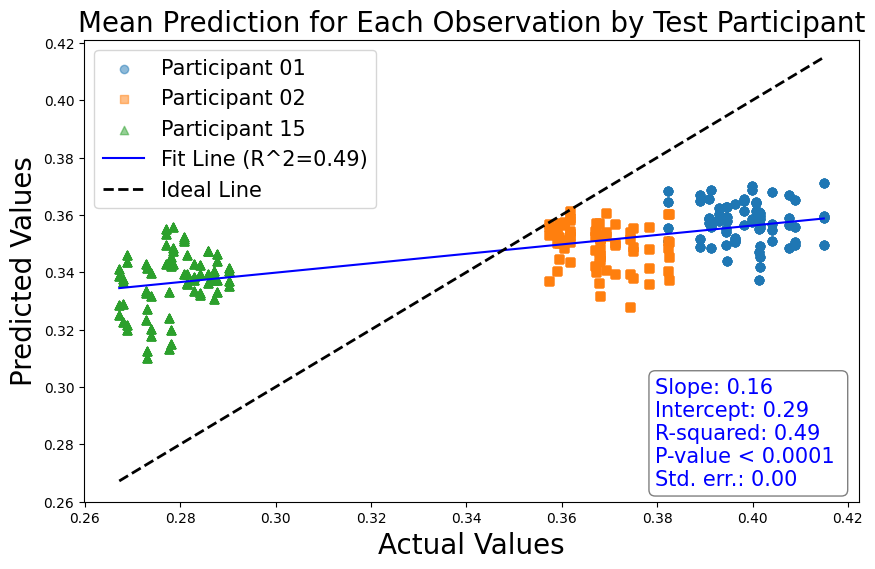

In [73]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
unique_participants = test_folders
plt.figure(figsize=(10, 6))

# Define markers and colors for participants
markers = ['o', 's', '^', '<', '>', 'p', '*', 'h', 'x', 'D']  # Example markers

# Prepare to collect all mean predictions and actuals
all_mean_predictions = []
all_mean_actuals = []

# Assuming `all_model_results` is structured like [(predictions, actuals, participant_ids), ...] for each model
for i, participant in enumerate(unique_participants):
    # Initialize lists to store individual observation means for this participant
    participant_observation_means_pred = []
    participant_observation_means_act = []

    # Collect all predictions and actuals for this participant across models
    for predictions, actuals, participant_ids in all_model_results:
        for obs_idx in range(len(participant_ids)):
            if participant_ids[obs_idx] == participant:
                # For each observation belonging to the current participant, collect across all models
                all_preds_for_obs = [predictions[obs_idx] for predictions, _, ids in all_model_results if ids[obs_idx] == participant]
                all_actuals_for_obs = [actuals[obs_idx] for _, actuals, ids in all_model_results if ids[obs_idx] == participant]
                
                # Compute the mean prediction for this observation across all models
                participant_observation_means_pred.append(np.mean(all_preds_for_obs))
                # The actuals should be the same across all models, so just take the mean to keep dimensions consistent
                participant_observation_means_act.append(np.mean(all_actuals_for_obs))
    
    # Add the computed means for this participant to the overall list
    all_mean_predictions.extend(participant_observation_means_pred)
    all_mean_actuals.extend(participant_observation_means_act)
    
    # Plot the mean predictions for this participant's observations
    marker = markers[i % len(markers)]  # Cycle through markers
    plt.scatter(participant_observation_means_act, participant_observation_means_pred, alpha=0.5, label=f'Participant {participant}', marker=marker)

# Perform linear regression on the aggregated means
slope, intercept, r_value, p_value, std_err = linregress(all_mean_actuals, all_mean_predictions)
line_x = np.linspace(min(all_mean_actuals), max(all_mean_actuals), 100)
line_y = slope * line_x + intercept

plt.plot(line_x, line_y, color='blue', label=f'Fit Line (R^2={r_value**2:.2f})')
plt.plot([min(all_mean_actuals), max(all_mean_actuals)], [min(all_mean_actuals), max(all_mean_actuals)], 'k--', lw=2, label='Ideal Line')

plt.legend(fontsize=15)
# Add text box for the regression info
textstr = '\n'.join((
    f'Slope: {slope:.2f}',
    f'Intercept: {intercept:.2f}',
    f'R-squared: {r_value**2:.2f}',
    f'P-value < 0.0001 ',
    f'Std. err.: {std_err:.2f}'
))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.text(0.737, 0.27, textstr, transform=plt.gca().transAxes, fontsize=15, verticalalignment='top', bbox=props, color='blue')
plt.ylim([min(all_mean_predictions)-.05,max(all_mean_predictions)+.05])
plt.xlabel('Actual Values', fontsize=20)
plt.ylabel('Predicted Values', fontsize=20)
plt.title('Mean Prediction for Each Observation by Test Participant', fontsize=20)
plt.show()

With Fine Tuning Training

In [ ]:
import torch
import numpy as np
from torch import optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# Assuming YourModelClass and YourDatasetClass are defined elsewhere
# from your_model_file import YourModelClass
# from your_dataset_file import YourDatasetClass

def load_model(model_path, device):
    """Load a pre-trained model."""
    model = YourModelClass()  # Replace with your model class
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    return model

def personalize_model(model, personalization_loader, device, epochs=3):
    """Fine-tunes the model on a small subset of a participant's data."""
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()  # Replace with your loss function
    
    for epoch in range(epochs):
        for inputs, labels in personalization_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

def evaluate_and_personalize_model(model, test_loader, personalization_loader, device):
    """Personalizes the model with a fraction of the test data, then evaluates it."""
    # First, personalize the model
    personalize_model(model, personalization_loader, device)
    
    # Then, evaluate the personalized model
    model.eval()
    predictions, actuals = [], []
    participant_ids = []  # To store participant IDs if needed
    with torch.no_grad():
        for inputs, labels, _, metadata in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())
            # Assuming metadata contains participant ID information
            participant_ids.extend([meta['participant_id'] for meta in metadata])
    return np.array(predictions), np.array(actuals), np.array(participant_ids)

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_dir = "/path/to/saved/models"  # Directory containing saved models
    root_dir = '/path/to/dataset/root'
    event_csv = '/path/to/event/csv'
    
    # Example to process a single model and participant
    model_path = os.path.join(model_dir, "example_model.pth")  # Use an actual model filename
    model = load_model(model_path, device)
    
    participant_id = "example_participant"  # Use an actual participant ID
    participant_dataset = StableRdmDataset(root_dir, event_csv, [participant_id])  # Adjust call as necessary
    personalization_indices, test_indices = train_test_split(range(len(participant_dataset)), test_size=0.9, random_state=42)
    
    personalization_dataset = Subset(participant_dataset, personalization_indices)
    test_dataset = Subset(participant_dataset, test_indices)
    
    personalization_loader = DataLoader(personalization_dataset, batch_size=2, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)
    
    predictions, actuals, participant_ids = evaluate_and_personalize_model(model, test_loader, personalization_loader, device)
    # Proceed with evaluating predictions...

if __name__ == "__main__":
    main()


Loop for kfold training

Starting Fold 1/5
Train folders: ['10' '24' '18' '08' '03' '14' '04' '05' '16' '01' '02' '15']
Test folders: ['13' '22' '12']
Epoch 1/15
----------
Train Loss: 0.0033

Epoch 2/15
----------
Train Loss: 0.0024

Epoch 3/15
----------
Train Loss: 0.0023

Epoch 4/15
----------
Train Loss: 0.0019

Epoch 5/15
----------
Train Loss: 0.0019

Epoch 6/15
----------
Train Loss: 0.0017

Epoch 7/15
----------
Train Loss: 0.0014

Epoch 8/15
----------
Train Loss: 0.0013

Epoch 9/15
----------
Train Loss: 0.0015

Epoch 10/15
----------
Train Loss: 0.0014

Epoch 11/15
----------
Train Loss: 0.0012

Epoch 12/15
----------
Train Loss: 0.0012

Epoch 13/15
----------
Train Loss: 0.0012

Epoch 14/15
----------
Train Loss: 0.0012

Epoch 15/15
----------
Train Loss: 0.0011

Training complete
Model saved to /Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/models_crossvalidation/model_fold_1.pth


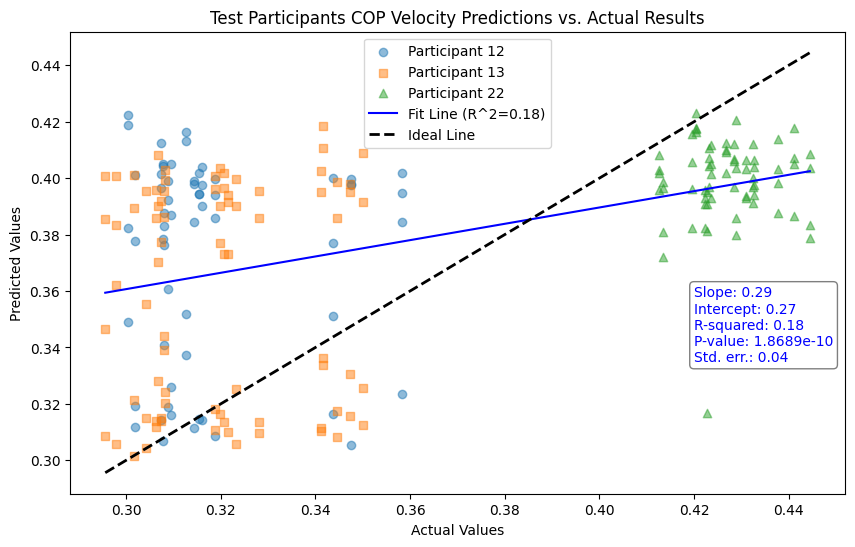

Starting Fold 2/5
Train folders: ['13' '22' '12' '08' '03' '14' '04' '05' '16' '01' '02' '15']
Test folders: ['10' '24' '18']
Epoch 1/15
----------
Train Loss: 0.0037

Epoch 2/15
----------
Train Loss: 0.0026

Epoch 3/15
----------
Train Loss: 0.0025

Epoch 4/15
----------
Train Loss: 0.0022

Epoch 5/15
----------
Train Loss: 0.0021

Epoch 6/15
----------
Train Loss: 0.0021

Epoch 7/15
----------
Train Loss: 0.0018

Epoch 8/15
----------
Train Loss: 0.0018

Epoch 9/15
----------
Train Loss: 0.0017

Epoch 10/15
----------
Train Loss: 0.0016

Epoch 11/15
----------
Train Loss: 0.0015

Epoch 12/15
----------
Train Loss: 0.0015

Epoch 13/15
----------
Train Loss: 0.0017

Epoch 14/15
----------
Train Loss: 0.0015

Epoch 15/15
----------
Train Loss: 0.0014

Training complete
Model saved to /Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/models_crossvalidation/model_fold_2.pth


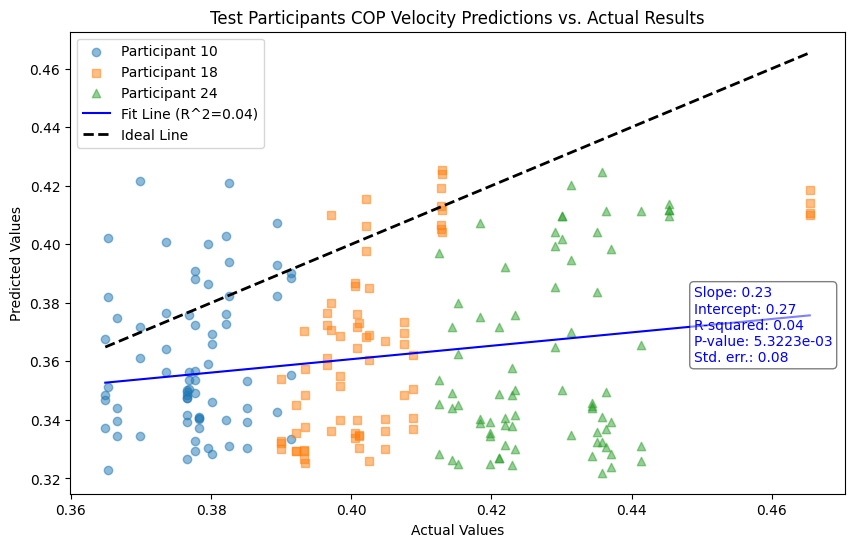

Starting Fold 3/5
Train folders: ['13' '22' '12' '10' '24' '18' '04' '05' '16' '01' '02' '15']
Test folders: ['08' '03' '14']
Epoch 1/15
----------
Train Loss: 0.0035

Epoch 2/15
----------
Train Loss: 0.0026

Epoch 3/15
----------
Train Loss: 0.0024

Epoch 4/15
----------
Train Loss: 0.0021

Epoch 5/15
----------
Train Loss: 0.0018

Epoch 6/15
----------
Train Loss: 0.0016

Epoch 7/15
----------
Train Loss: 0.0014

Epoch 8/15
----------
Train Loss: 0.0013

Epoch 9/15
----------
Train Loss: 0.0017

Epoch 10/15
----------
Train Loss: 0.0012

Epoch 11/15
----------
Train Loss: 0.0011

Epoch 12/15
----------
Train Loss: 0.0011

Epoch 13/15
----------
Train Loss: 0.0011

Epoch 14/15
----------
Train Loss: 0.0009

Epoch 15/15
----------
Train Loss: 0.0009

Training complete
Model saved to /Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/models_crossvalidation/model_fold_3.pth


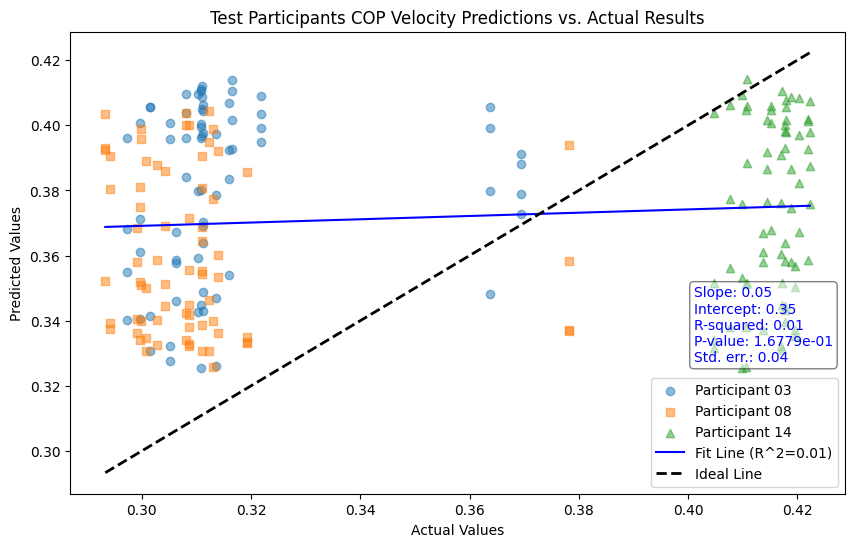

Starting Fold 4/5
Train folders: ['13' '22' '12' '10' '24' '18' '08' '03' '14' '01' '02' '15']
Test folders: ['04' '05' '16']
Epoch 1/15
----------
Train Loss: 0.0037

Epoch 2/15
----------
Train Loss: 0.0027

Epoch 3/15
----------
Train Loss: 0.0026

Epoch 4/15
----------
Train Loss: 0.0024

Epoch 5/15
----------
Train Loss: 0.0022

Epoch 6/15
----------
Train Loss: 0.0023

Epoch 7/15
----------
Train Loss: 0.0020

Epoch 8/15
----------
Train Loss: 0.0019

Epoch 9/15
----------
Train Loss: 0.0019

Epoch 10/15
----------
Train Loss: 0.0031

Epoch 11/15
----------
Train Loss: 0.0021

Epoch 12/15
----------
Train Loss: 0.0017

Epoch 13/15
----------
Train Loss: 0.0016

Epoch 14/15
----------
Train Loss: 0.0016

Epoch 15/15
----------
Train Loss: 0.0018

Training complete
Model saved to /Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/models_crossvalidation/model_fold_4.pth


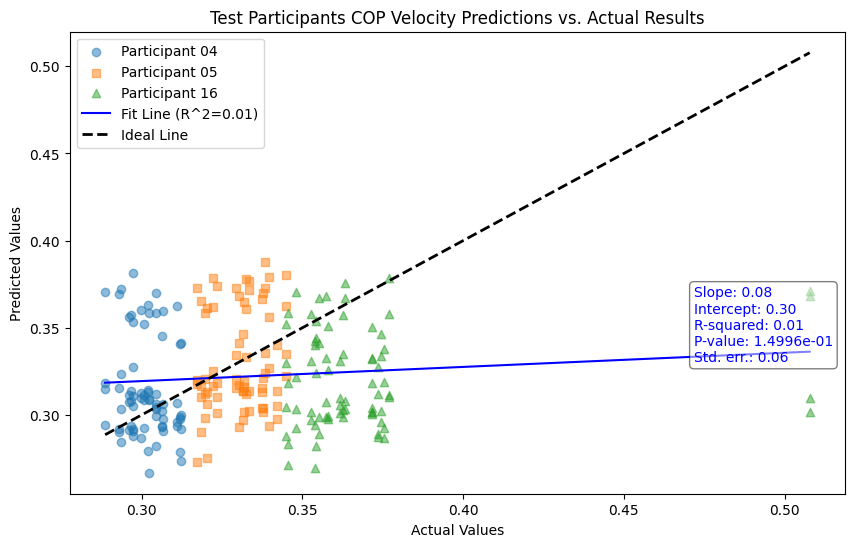

Starting Fold 5/5
Train folders: ['13' '22' '12' '10' '24' '18' '08' '03' '14' '04' '05' '16']
Test folders: ['01' '02' '15']
Epoch 1/15
----------
Train Loss: 0.0047

Epoch 2/15
----------
Train Loss: 0.0031

Epoch 3/15
----------
Train Loss: 0.0028

Epoch 4/15
----------
Train Loss: 0.0027

Epoch 5/15
----------
Train Loss: 0.0027

Epoch 6/15
----------
Train Loss: 0.0025

Epoch 7/15
----------
Train Loss: 0.0025

Epoch 8/15
----------
Train Loss: 0.0024

Epoch 9/15
----------
Train Loss: 0.0022

Epoch 10/15
----------
Train Loss: 0.0024

Epoch 11/15
----------
Train Loss: 0.0021

Epoch 12/15
----------
Train Loss: 0.0020

Epoch 13/15
----------
Train Loss: 0.0019

Epoch 14/15
----------
Train Loss: 0.0019

Epoch 15/15
----------
Train Loss: 0.0017

Training complete
Model saved to /Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/models_crossvalidation/model_fold_5.pth


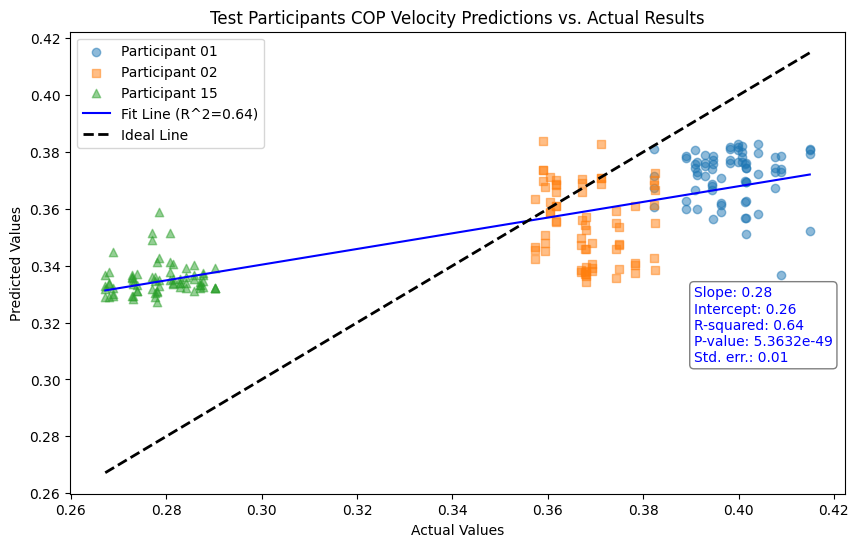

Model training and testing complete.


In [22]:

# Define the root directory and event CSV file path
root_dir = '/Volumes/FourTBLaCie/Yoga_Study_RADAR_Stable_1Ch'
event_csv = "/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/csvs/MOCAP_FP_RADAR_FU_Stable_Break_FD_TIME_FRAMES_v3.csv"

# Get all folders and shuffle them randomly
all_folders = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
random.seed(42)
random.shuffle(all_folders)

# Define the setup_loaders function
def setup_loaders(root_dir, event_csv, folders):
    datasets = {x: StableRdmDataset(root_dir, event_csv, folders[x], label_type="avg_speed") for x in ['train', 'test']}
    loaders = {x: DataLoader(datasets[x], batch_size=2, shuffle=True if x == 'train' else False, collate_fn=StableRdmDataset.collate_fn) for x in datasets}
    return loaders

# Assign folders to each data split
folders = {
    'train': train_folders,
    'test': test_folders
}

# Create the DataLoaders
loaders = setup_loaders(root_dir, event_csv, folders)
train_loader, test_loader = loaders['train'], loaders['test']

# Prepare K-Fold Cross-validation
kf = KFold(n_splits=5)  # Adjust the number of splits as needed

for fold, (train_index, test_index) in enumerate(kf.split(all_folders)):
    print(f'Starting Fold {fold+1}/{kf.get_n_splits()}')
    train_folders = np.array(all_folders)[train_index]
    test_folders = np.array(all_folders)[test_index]
    print(f'Train folders: {train_folders}')
    print(f'Test folders: {test_folders}')
    
    # Use all data for training and testing in each fold
    folders = {'train': train_folders.tolist(), 'test': test_folders.tolist()}
    loaders = setup_loaders(root_dir, event_csv, folders)
    train_loader = loaders['train']
    test_loader = loaders['test']

    # Initialize the model
    model = RdmCNNLSTMModel(num_channels=1, hidden_dim=128, lstm_layers=2, bidirectional=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Train the model on this fold's training data
    # Make sure to define or adjust train_model function to fit this use case
    model = train_model(model, train_loader, criterion, optimizer, num_epochs=15, device=device)
    
    model_save_dir = "/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/models_crossvalidation"
    model_save_path = os.path.join(model_save_dir, f'model_fold_{fold+1}.pth')
    torch.save(model.state_dict(), model_save_path)
    print(f'Model saved to {model_save_path}')
    
    model.eval()  # Set the model to evaluation mode
    predictions = []
    actuals = []
    participant_ids = []

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels, _, metadata in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Generate predictions
            output = model(inputs)

            # Flatten and convert to list
            predictions.extend(output.view(-1).cpu().tolist())
            actuals.extend(labels.view(-1).cpu().tolist())

            # Extract participant IDs from metadata and extend the list
            participant_ids.extend([meta['RADAR_capture'][:2] for meta in metadata])

    # PLOT the Test Predictions
    # Assuming predictions, actuals, and participant_ids have been defined earlier
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    participant_ids = np.array(participant_ids)

    unique_participants = np.unique(participant_ids)
    slope, intercept, r_value, p_value, std_err = stats.linregress(actuals, predictions)

    # Create a sequence of numbers from min to max actual values for the line of best fit
    line_x = np.linspace(min(actuals), max(actuals), 100)
    line_y = slope * line_x + intercept

    # Plotting
    plt.figure(figsize=(10, 6))
    # Define a list of markers
    markers = ['o', 's', '^', 'v', '<', '>', 'p', '*', 'h', 'x', 'D']

    # Ensure we have enough markers, repeat if necessary
    if len(markers) < len(unique_participants):
        markers = markers * (len(unique_participants) // len(markers) + 1)

    # Iterate over participants using a different marker for each
    for i, participant in enumerate(unique_participants):
        idx = participant_ids == participant
        plt.scatter(actuals[idx], predictions[idx], marker=markers[i], alpha=0.5, label=f'Participant {participant}')

    # Plot the line of best fit
    plt.plot(line_x, line_y, color='blue', label=f'Fit Line (R^2={r_value**2:.2f})')

    # Plot the diagonal line for reference
    plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'k--', lw=2, label='Ideal Line')

    # Add a legend
    plt.legend()

    # Add text box for the regression info
    textstr = '\n'.join((
        f'Slope: {slope:.2f}',
        f'Intercept: {intercept:.2f}',
        f'R-squared: {r_value**2:.2f}',
        f'P-value: {p_value:.4e}',
        f'Std. err.: {std_err:.2f}'
    ))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    plt.text(0.805, 0.45, textstr, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=props, color='blue')
    plt.title('Test Participants COP Velocity Predictions vs. Actual Results')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()


# Implement your testing logic here
# This might include evaluating the model's performance and printing or storing the test results

print("Model training and testing complete.")